In [1]:
!python -m pip install --no-index --find-links=/kaggle/input/pip-download-for-segmentation-models-pytorch segmentation-models-pytorch
!pip install einops

Looking in links: /kaggle/input/pip-download-for-segmentation-models-pytorch
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/segmentation_models_pytorch-0.3.3-py3-none-any.whl
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/pretrainedmodels-0.7.4.tar.gz (from segmentation-models-pytorch)
  Preparing metadata (setup.py) ... done
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/efficientnet_pytorch-0.7.1.tar.gz (from segmentation-models-pytorch)
  Preparing metadata (setup.py) ... done
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/timm-0.9.2-py3-none-any.whl (from segmentation-models-pytorch)
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/munch-4.0.0-py2.py3-none-any.whl (from pretrainedmodels==0.7.4->segmentation-models-pytorch)
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=1d3d6bafb3570384def30981b7128fc0590a5

In [2]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.1 MB/s eta 0:00:00a 0:00:01


In [3]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import cv2
import albumentations as A
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import plotly.graph_objects as go
from IPython.display import display, clear_output
import plotly.express as px
import pandas as pd
import random
from torch import nn

from torch.cuda.amp import GradScaler, autocast
import math
import tqdm
import monai

2024-11-14 13:46:38.824589: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 13:46:38.824731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 13:46:38.970497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
class newDataset(Dataset):
    def __init__(self, image_files, mask_files, input_size=(512,512), transform=None):
        self.image_files=image_files
        self.mask_files=mask_files
        self.input_size=input_size
        self.transform=transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path=self.image_files[idx]
        image = cv2.imread(image_path, 0)
        orig_size = image.shape
        
        image = self.image_histogram_equalization(image.astype('float32'))
        image = image/image.max()
        image=torch.tensor(image)
        if self.transform:
            image=self.augment_image(image)
        
        mask = cv2.imread(self.mask_files[idx], 0)
        mask = mask / 255.
        mask=torch.tensor(mask)
        
        return image, mask
    
    def image_histogram_equalization(self, image, number_bins=256):
        image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
        cdf = image_histogram.cumsum() 
        cdf = (number_bins-1) * cdf / cdf[-1] 
        
        image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
    
        return image_equalized.reshape(image.shape)
    
    def augment_image(self, image):
        shape = (*image.shape, 1 )
        image_np = image.reshape(shape).numpy()
        augmented = self.transform(image = image_np)
        augmented_image = augmented['image']
        augmented_image = augmented_image.reshape(augmented_image.shape[:-1])
        augmented_image = torch.tensor(augmented_image, dtype=torch.float32)

        
        return augmented_image

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    if rle == '':
        rle = '1 0'
    return rle


def remove_small_objects(img, min_size):
    # Find all connected components (labels)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)

    # Create a mask where small objects are removed
    new_img = np.zeros_like(img)
    for label in range(1, num_labels):
        if stats[label, cv2.CC_STAT_AREA] >= min_size:
            new_img[labels == label] = 255

    return new_img


class patchImage():
    def __init__(self, patch_size=768, patch_overlap=0.15):
        self.patch_size = patch_size
        self.patch_overlap = patch_overlap
        
    def extract_patches(self, image):
        patches = []
        def calculate_dynamic_step(img_dim, patch_dim, overlap_fraction):
            overlap = int(patch_dim * overlap_fraction)
            step = patch_dim - overlap
            num_patches = math.ceil((img_dim - overlap) / step)
            step = (img_dim - patch_dim) / (num_patches - 1) if num_patches > 1 else 0
            return step, num_patches

        step_h, num_patches_h = calculate_dynamic_step(image.shape[0], self.patch_size, self.patch_overlap)
        step_w, num_patches_w = calculate_dynamic_step(image.shape[1], self.patch_size, self.patch_overlap)
        patches = []
        
        for i in range(num_patches_h):
            for j in range(num_patches_w):
                y = int(i * step_h)
                x = int(j * step_w)
                patch_img = image[y:y + self.patch_size, x:x + self.patch_size]
                patches.append(patch_img.numpy())

        return patches

    
    def reconstruct_from_patches(self, patches, original_shape, patch_size=768, patch_overlap=0.2):
        # Calculate the step size and number of patches along each dimension
        overlap = int(patch_size * patch_overlap)
        step = patch_size - overlap

        # Calculate the dynamic step if needed, as in the extract_patches function
        def calculate_dynamic_step(img_dim, patch_dim, num_patches):
            if num_patches > 1:
                return (img_dim - patch_dim) / (num_patches - 1)
            else:
                return 0

        # Determine the number of patches along each dimension
        num_patches_h = int(np.ceil((original_shape[0] - overlap) / step))
        num_patches_w = int(np.ceil((original_shape[1] - overlap) / step))

        # Recalculate step size based on the actual number of patches (for edge cases)
        step_h = calculate_dynamic_step(original_shape[0], patch_size, num_patches_h)
        step_w = calculate_dynamic_step(original_shape[1], patch_size, num_patches_w)

        # Initialize an empty array to hold the reconstructed image
        reconstructed_image = np.zeros(original_shape, dtype=patches[0].dtype)

        # Loop through each patch and place it in the reconstructed image
        patch_idx = 0
        for i in range(num_patches_h):
            for j in range(num_patches_w):
                y = int(i * step_h)
                x = int(j * step_w)

                # If a patch goes beyond the image boundaries, trim the patch to fit
                patch = patches[patch_idx]
                patch_h, patch_w = patch.shape[:2]
                end_y = min(y + patch_h, original_shape[0])
                end_x = min(x + patch_w, original_shape[1])

                # Place the patch in the reconstructed image
                reconstructed_image[y:end_y, x:end_x] = patch[:(end_y-y), :(end_x-x)]
                patch_idx += 1

        return reconstructed_image

class SegmentationPerformance:
    def __init__(self, num_samples=5, device='cuda'):
        self.metrics_sum = {'Precision': 0, 'Recall': 0, 'Accuracy': 0, 'Dice Coefficient': 0, 'IoU': 0}
        self.count = 0
        self.total_loss = 0.0
        self.total_loss1 = 0.0
        self.saved_samples = []
        self.num_samples = num_samples
        self.device = device
        self.surface_dice = 0.0

    def precision_score_(self, groundtruth_mask, pred_mask):
        intersect = torch.sum(pred_mask * groundtruth_mask)
        total_pixel_pred = torch.sum(pred_mask)
        precision = intersect.float() / total_pixel_pred.float() if total_pixel_pred != 0 else torch.tensor(0.0, device=groundtruth_mask.device)
        return precision.item()

    def recall_score_(self, groundtruth_mask, pred_mask):
        intersect = torch.sum(pred_mask * groundtruth_mask)
        total_pixel_truth = torch.sum(groundtruth_mask)
        recall = intersect.float() / total_pixel_truth.float() if total_pixel_truth != 0 else torch.tensor(0.0, device=groundtruth_mask.device)
        return recall.item()

    def accuracy(self, groundtruth_mask, pred_mask):
        intersect = torch.sum(pred_mask * groundtruth_mask)
        union = torch.sum(pred_mask) + torch.sum(groundtruth_mask) - intersect
        xor = torch.sum(groundtruth_mask == pred_mask)
        acc = xor.float() / (union + xor - intersect).float() if (union + xor - intersect) != 0 else torch.tensor(0.0, device=self.device)
        return acc.item()

    def dice_coef(self, groundtruth_mask, pred_mask):
        intersect = torch.sum(pred_mask * groundtruth_mask)
        total_sum = torch.sum(pred_mask) + torch.sum(groundtruth_mask)
        dice = (2 * intersect).float() / total_sum.float() if total_sum != 0 else torch.tensor(0.0, device=self.device)
        return dice.item()

    def iou(self, groundtruth_mask, pred_mask):
        intersect = torch.sum(pred_mask * groundtruth_mask)
        union = torch.sum(pred_mask) + torch.sum(groundtruth_mask) - intersect
        iou = intersect.float() / union.float() if union != 0 else torch.tensor(0.0, device=self.device)
        return iou.item()

    def update_metrics_and_save_sample(self, groundtruth_mask, pred_mask, loss=None,loss1=None, image=None, gt_mask=None, pred_mask_sample=None):
        self.metrics_sum['Precision'] += self.precision_score_(groundtruth_mask, pred_mask)
        self.metrics_sum['Recall'] += self.recall_score_(groundtruth_mask, pred_mask)
        self.metrics_sum['Accuracy'] += self.accuracy(groundtruth_mask, pred_mask)
        self.metrics_sum['Dice Coefficient'] += self.dice_coef(groundtruth_mask, pred_mask)
        self.metrics_sum['IoU'] += self.iou(groundtruth_mask, pred_mask)
        if loss is not None:
            self.total_loss += loss.item()

        if loss1 is not None:
            self.total_loss1 += loss1.item()
    
        if image is not None:
            # Convert to CPU for plotting
            self.saved_samples.append((image.cpu().numpy(), gt_mask.cpu().numpy(), pred_mask_sample.cpu().numpy()))

        self.count += 1

    def get_average_metrics(self):
        average_metrics = {metric: value / self.count for metric, value in self.metrics_sum.items()}
        average_metrics['Average Loss'] = self.total_loss / self.count if self.count != 0 else 0
        average_metrics['Average Loss1'] = self.total_loss1 / self.count if self.count != 0 else 0
        average_metrics['Avg Surface Dice'] = self.surface_dice 
        return average_metrics

    def report(self):
        metrics = self.get_average_metrics()
        return pd.DataFrame([metrics])
    
    def plot_saved_samples(self, figsize=(15, 15)):
        if not self.saved_samples:
            print("No samples saved for plotting.")
            return

        plt.figure(figsize=figsize)

        for i, (image, groundtruth_mask, predicted_mask) in enumerate(self.saved_samples):
            if image.ndim == 3:
                if image.shape[0] == 3:  
                    image = image.transpose(1, 2, 0)
                elif image.shape[0] == 1:  
                    image = image.squeeze(0)  #

            image = (image - image.min()) / (image.max() - image.min()) if image.max() != image.min() else image

            plt.subplot(self.num_samples, 3, i * 3 + 1)
            plt.imshow(image, cmap='gray' if image.ndim == 2 else None)
            plt.title('Image')
            plt.axis('off')

            plt.subplot(self.num_samples, 3, i * 3 + 2)
            plt.imshow(groundtruth_mask.squeeze(), cmap='gray')
            plt.title('Ground Truth Mask')
            plt.axis('off')

            plt.subplot(self.num_samples, 3, i * 3 + 3)
            plt.imshow(predicted_mask.squeeze(), cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')

        plt.tight_layout()
        plt.show()


In [5]:
_NEIGHBOUR_CODE_TO_NORMALS = [[[0, 0, 0]], [[0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
                              [[0.125, -0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]], [[-0.125, 0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125]],
                              [[-0.5, 0.0, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [0.5, 0.0, 0.0]],
                              [[0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25]],
                              [[-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.5, 0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, 0.25],
                               [-0.125, -0.125, -0.125]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.125, -0.125, -0.125], [-0.25, -0.25, -0.25],
                               [0.25, 0.25, 0.25], [0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.125, 0.125, 0.125], [0.375, 0.375, 0.375],
                               [0.0, -0.25, 0.25], [-0.25, 0.0, 0.25]],
                              [[0.125, -0.125, -0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.375, 0.375, 0.375], [0.0, 0.25, -0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25], [0.125, 0.125, 0.125]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25]], [[0.125, -0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.25, -0.0, -0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.375, -0.375, 0.375], [-0.0, 0.25, 0.25],
                               [0.125, 0.125, -0.125], [-0.25, -0.0, -0.25]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, 0.25, -0.25], [0.25, 0.25, -0.25],
                               [0.125, 0.125, -0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[0.125, -0.125, 0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.0, 0.25, -0.25], [0.375, -0.375, -0.375],
                               [-0.125, 0.125, 0.125], [0.25, 0.25, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0]],
                              [[0.0, 0.5, 0.0], [-0.25, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.0, 0.5, 0.0], [0.125, -0.125, 0.125],
                               [-0.25, 0.25, -0.25]],
                              [[0.0, 0.5, 0.0], [0.0, -0.5, 0.0]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0],
                               [0.125, -0.125, 0.125]],
                              [[-0.375, -0.375, -0.375], [-0.25, 0.0, 0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[0.125, 0.125, 0.125], [0.0, -0.5, 0.0],
                               [-0.25, -0.25, -0.25], [-0.125, -0.125,
                                                       -0.125]],
                              [[0.0, -0.5, 0.0], [-0.25, -0.25, -0.25],
                               [-0.125, -0.125, -0.125]],
                              [[-0.125, 0.125, 0.125], [0.25, -0.25, 0.0],
                               [-0.25, 0.25, 0.0]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.375, 0.375, -0.375], [-0.25, -0.25, 0.0],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0],
                               [0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.25, -0.25, 0.0],
                               [-0.25, -0.25, 0.0]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0]],
                              [[-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, -0.25, 0.0],
                               [0.25, 0.25, -0.0]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.375, -0.375, 0.375], [0.0, -0.25, -0.25],
                               [-0.125, 0.125, -0.125], [0.25, 0.25, 0.0]],
                              [[-0.125, -0.125, 0.125], [-0.125, 0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [-0.25, 0.0, 0.25]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.25, 0.25, -0.25], [-0.25, 0.25, -0.25],
                               [-0.125, 0.125, -0.125],
                               [-0.125, 0.125, -0.125]],
                              [[-0.25, 0.0, -0.25], [0.375, -0.375, -0.375],
                               [0.0, 0.25, -0.25], [-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
                              [[-0.0, 0.0, 0.5], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [0.25, 0.0, -0.25]],
                              [[-0.25, -0.0, -0.25], [-0.375, 0.375, 0.375],
                               [-0.25, -0.25, 0.0], [-0.125, 0.125, 0.125]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125],
                               [0.25, 0.25, 0.25], [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25],
                               [-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
                              [[0.125, -0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.25, 0.0, 0.25], [-0.375, -0.375, 0.375],
                               [-0.25, 0.25, 0.0], [-0.125, -0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.0, -0.25, 0.25],
                               [0.0, 0.25, -0.25]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25], [-0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, -0.125]],
                              [[0.5, 0.0, -0.0], [0.25, -0.25, -0.25],
                               [0.125, -0.125, -0.125]],
                              [[-0.25, 0.25, 0.25], [-0.125, 0.125, 0.125],
                               [-0.25, 0.25, 0.25], [0.125, -0.125, -0.125]],
                              [[0.375, -0.375, 0.375], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[0.0, -0.5, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.375, -0.375, 0.375], [0.25, -0.25, 0.0],
                               [0.0, 0.25, 0.25], [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [-0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.0, 0.25, 0.25],
                               [0.0, 0.25, 0.25]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, 0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125]], [[0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, 0.125, 0.125]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
                              [[0.125, 0.125, 0.125], [0.0, 0.25, 0.25],
                               [0.0, 0.25, 0.25]],
                              [[-0.125, 0.125, 0.125], [-0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[-0.375, -0.375, 0.375], [0.25, -0.25, 0.0],
                               [0.0, 0.25, 0.25], [-0.125, -0.125, 0.125]],
                              [[0.0, -0.5, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.375, -0.375, 0.375], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[-0.25, 0.25, 0.25], [-0.125, 0.125, 0.125],
                               [-0.25, 0.25, 0.25], [0.125, -0.125, -0.125]],
                              [[0.5, 0.0, -0.0], [0.25, -0.25, -0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25], [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.0, -0.25, 0.25],
                               [0.0, 0.25, -0.25]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
                              [[0.125, 0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.25, 0.0, 0.25], [-0.375, -0.375, 0.375],
                               [-0.25, 0.25, 0.0], [-0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125],
                               [0.25, 0.25, 0.25], [0.0, 0.0, 0.5]],
                              [[-0.0, 0.0, 0.5], [0.0, 0.0, 0.5]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [-0.375, 0.375, 0.375],
                               [-0.25, -0.25, 0.0], [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [0.25, 0.0, -0.25]],
                              [[-0.0, 0.0, 0.5], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
                              [[0.5, 0.0, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, -0.25], [0.375, -0.375, -0.375],
                               [0.0, 0.25, -0.25], [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.25, -0.25], [-0.25, 0.25, -0.25],
                               [-0.125, 0.125, -0.125],
                               [-0.125, 0.125, -0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [-0.25, 0.0, 0.25]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.125, 0.125,
                                                         0.125]],
                              [[0.375, -0.375, 0.375], [0.0, -0.25, -0.25],
                               [-0.125, 0.125, -0.125], [0.25, 0.25, 0.0]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25]],
                              [[-0.125, -0.125, 0.125], [-0.25, -0.25, 0.0],
                               [0.25, 0.25, -0.0]],
                              [[-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0]],
                              [[0.125, 0.125, 0.125], [-0.25, -0.25, 0.0],
                               [-0.25, -0.25, 0.0]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0],
                               [-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0],
                               [-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.375, 0.375, -0.375], [-0.25, -0.25, 0.0],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.25, -0.25, 0.0],
                               [-0.25, 0.25, 0.0]],
                              [[0.0, -0.5, 0.0], [-0.25, -0.25, -0.25],
                               [-0.125, -0.125, -0.125]],
                              [[0.125, 0.125, 0.125], [0.0, -0.5, 0.0],
                               [-0.25, -0.25, -0.25], [-0.125, -0.125,
                                                       -0.125]],
                              [[-0.375, -0.375, -0.375], [-0.25, 0.0, 0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0],
                               [0.125, -0.125, 0.125]],
                              [[0.0, 0.5, 0.0], [0.0, -0.5, 0.0]],
                              [[0.0, 0.5, 0.0], [0.125, -0.125, 0.125],
                               [-0.25, 0.25, -0.25]],
                              [[0.0, 0.5, 0.0], [-0.25, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.0, 0.25, -0.25], [0.375, -0.375, -0.375],
                               [-0.125, 0.125, 0.125], [0.25, 0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.125, -0.125, 0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.25, 0.25, -0.25], [0.25, 0.25, -0.25],
                               [0.125, 0.125, -0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.375, -0.375, 0.375], [-0.0, 0.25, 0.25],
                               [0.125, 0.125, -0.125], [-0.25, -0.0, -0.25]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.25, -0.0, -0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25], [0.125, 0.125, 0.125]],
                              [[0.375, 0.375, 0.375], [0.0, 0.25, -0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[0.125, -0.125, -0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.125, 0.125, 0.125], [0.375, 0.375, 0.375],
                               [0.0, -0.25, 0.25], [-0.25, 0.0, 0.25]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[-0.125, -0.125, -0.125], [-0.25, -0.25, -0.25],
                               [0.25, 0.25, 0.25], [0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, 0.25],
                               [-0.125, -0.125, -0.125]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[0.0, -0.5, 0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25]],
                              [[0.125, -0.125, -0.125]],
                              [[0.5, 0.0, 0.0], [0.5, 0.0, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125]],
                              [[0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25]],
                              [[0.125, 0.125, 0.125], [-0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25]],
                              [[0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
                              [[-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125]], [[0, 0, 0]]]


import torch.nn as nn

device = torch.device('cuda')  # can be 'cpu'

# PyTorch version dependence on index data type
torch_ver_major = int(torch.__version__.split('.')[0])
dtype_index = torch.int32 if torch_ver_major >= 2 else torch.long

def create_table_neighbour_code_to_surface_area(spacing_mm):
    """Returns an array mapping neighbourhood code to the surface elements area.

  Note that the normals encode the initial surface area. This function computes
  the area corresponding to the given `spacing_mm`.

  Args:
    spacing_mm: 3-element list-like structure. Voxel spacing in x0, x1 and x2
      direction.
  """
    # compute the area for all 256 possible surface elements
    # (given a 2x2x2 neighbourhood) according to the spacing_mm
    neighbour_code_to_surface_area = np.zeros([256])
    for code in range(256):
        normals = np.array(_NEIGHBOUR_CODE_TO_NORMALS[code])
        sum_area = 0
        for normal_idx in range(normals.shape[0]):
            # normal vector
            n = np.zeros([3])
            n[0] = normals[normal_idx, 0] * spacing_mm[1] * spacing_mm[2]
            n[1] = normals[normal_idx, 1] * spacing_mm[0] * spacing_mm[2]
            n[2] = normals[normal_idx, 2] * spacing_mm[0] * spacing_mm[1]
            area = np.linalg.norm(n)
            sum_area += area
        neighbour_code_to_surface_area[code] = sum_area

    return neighbour_code_to_surface_area.astype(np.float32)

def rle_decode(mask_rle: str, shape: tuple) -> np.array:
    """
    Decode rle string
    https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode/script
    https://www.kaggle.com/stainsby/fast-tested-rle

    Args:
      mask_rle: run length (rle) as string
      shape: (height, width) of the mask

    Returns:
      array[uint8], 1 - mask, 0 - background
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def compute_area(y: list, unfold: nn.Unfold, area: torch.Tensor) -> torch.Tensor:
    """
    Args:
      y (list[Tensor]): A pair of consecutive slices of mask
      unfold: nn.Unfold(kernel_size=(2, 2), padding=1)
      area (Tensor): surface area for 256 patterns (256, )

    Returns:
      Surface area of surface in 2x2x2 cube
    """
    # Two layers of segmentation masks
    yy = torch.stack(y, dim=0).to(torch.float16).unsqueeze(0)
    # (batch_size=1, nch=2, H, W) 
    # bit (0/1) but unfold requires float

    # unfold slides through the volume like a convolution
    # 2x2 kernel returns 8 values (2 channels * 2x2)
    cubes_float = unfold(yy).squeeze(0)  # (8, n_cubes)

    # Each of the 8 values are either 0 or 1
    # Convert those 8 bits to one uint8
    cubes_byte = torch.zeros(cubes_float.size(1), dtype=dtype_index, device=device)
    # indices are required to be int32 or long for area[cube_byte] below, not uint8
    # Can be int32 for torch 2.0.0, int32 raise IndexError in torch 1.13.1.
    
    for k in range(8):
        cubes_byte += cubes_float[k, :].to(dtype_index) << k

    # Use area lookup table: pattern index -> area [float]
    cubes_area = area[cubes_byte]

    return cubes_area


def compute_surface_dice_score(submit: pd.DataFrame, label: pd.DataFrame) -> float:
    """
    Compute surface Dice score for one 3D volume

    submit (pd.DataFrame): submission file with id and rle
    label (pd.DataFrame): ground truth id, rle, and also image height, width
    """
    # submit and label must contain exact same id in same order
    assert (submit['id'] == label['id']).all()
    assert len(label) > 0

    # All height, width must be the same
    len(label['height'].unique()) == 1
    len(label['width'].unique()) == 1

    # Surface area lookup table: Tensor[float32] (256, )
    area = create_table_neighbour_code_to_surface_area((1, 1, 1))
    area = torch.from_numpy(area).to(device)  # torch.float32

    # Slide through the volume like a convolution
    unfold = torch.nn.Unfold(kernel_size=(2, 2), padding=1)

    r = label.iloc[0]
    h, w = r['height'], r['width']
    n_slices = len(label)

    # Padding before first slice
    y0 = y0_pred = torch.zeros((h, w), dtype=torch.uint8, device=device)

    num = 0     # numerator of surface Dice
    denom = 0   # denominator
    for i in range(n_slices + 1):
        # Load one slice
        if i < n_slices:
            r = label.iloc[i]
            y1 = rle_decode(r['rle'], (h, w))
            y1 = torch.from_numpy(y1).to(device)

            r = submit.iloc[i]
            y1_pred = rle_decode(r['rle'], (h, w))
            y1_pred = torch.from_numpy(y1_pred).to(device)
        else:
            # Padding after the last slice
            y1 = y1_pred = torch.zeros((h, w), dtype=torch.uint8, device=device)

        # Compute the surface area between two slices (n_cubes,)
        area_pred = compute_area([y0_pred, y1_pred], unfold, area)
        area_true = compute_area([y0, y1], unfold, area)

        # True positive cube indices
        idx = torch.logical_and(area_pred > 0, area_true > 0)

        # Surface dice numerator and denominator
        num += area_pred[idx].sum() + area_true[idx].sum()
        denom += area_pred.sum() + area_true.sum()

        # Next slice
        y0 = y1
        y0_pred = y1_pred

    dice = num / denom.clamp(min=1e-8)
    return dice.item()

In [6]:
from sklearn.model_selection import train_test_split
base_path = "/kaggle/input/blood-vessel-segmentation/train"
datasets = ["kidney_1_dense", "kidney_1_voi", "kidney_2", "kidney_3_sparse"]

image_files = []
labels_files = []
for dataset in datasets:
        print(dataset)
        images_path = os.path.join(base_path,dataset,"images")
        label_path = os.path.join(base_path,dataset,"labels")
        print(images_path)

        image_files.extend(sorted([os.path.join(images_path,f) for f in os.listdir(images_path) if f.endswith('.tif')]))
        labels_files.extend(sorted([os.path.join(label_path,f) for f in os.listdir(label_path) if f.endswith('.tif')]))

train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(
        image_files, labels_files, test_size=0.15, random_state=42)
val_image_files[:5]

kidney_1_dense
/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images
kidney_1_voi
/kaggle/input/blood-vessel-segmentation/train/kidney_1_voi/images
kidney_2
/kaggle/input/blood-vessel-segmentation/train/kidney_2/images
kidney_3_sparse
/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/images


['/kaggle/input/blood-vessel-segmentation/train/kidney_2/images/1320.tif',
 '/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/images/0184.tif',
 '/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/images/0153.tif',
 '/kaggle/input/blood-vessel-segmentation/train/kidney_2/images/0496.tif',
 '/kaggle/input/blood-vessel-segmentation/train/kidney_2/images/0016.tif']

In [ ]:
transform = A.Compose([
    A.Resize(512,512, interpolation=cv2.INTER_NEAREST)
])
dataset = newDataset(
    val_image_files, 
    val_mask_files,
    transform=None)

In [ ]:
im, _ = dataset[0]
plt.imshow(im)


In [ ]:
transform = A.Compose([
    A.Resize(512,512, interpolation=cv2.INTER_NEAREST)
])
patch = patchImage()
tmp = patch.extract_patches(dataset[0][0])
patches = []
for i in tmp:
    patches.append(transform(image=i)['image'])
len(patches)


In [ ]:
transform_back = A.Compose([
    A.Resize(768,768, interpolation=cv2.INTER_NEAREST)
])
patches_rs = []
for i in patches:
    patches_rs.append(transform_back(image=i)['image'])
    
img = patch.reconstruct_from_patches(patches_rs, dataset[0][0].shape)
plt.imshow(img)

In [ ]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {}


model = smp.UnetPlusPlus(
        encoder_name='resnext101_32x16d',
        encoder_weights=None,
        decoder_attention_type="scse",
        in_channels=1
    ).to(device)

models['/kaggle/input/models-full/best_model_patches_resnext101_32x16d.pth'] = model

model = smp.UnetPlusPlus(
    encoder_name='dpn98',
    encoder_weights=None,
    decoder_attention_type="scse",
    in_channels=1
).to(device)

models['/kaggle/input/models-full/patches_dpn98.pth'] = model


#maxvit
model = smp.UnetPlusPlus(
    encoder_name='tu-maxvit_base_tf_512',
    encoder_weights=None,
    decoder_attention_type="scse",
    in_channels=1
).to(device)
models[f'/kaggle/input/models_new/pytorch/default/1/{model.name}.pth'] = model

#swin
model = monai.networks.nets.SwinUNETR(
    img_size=(512,512), 
    in_channels=1, 
    out_channels=1, 
    use_checkpoint=True, 
    spatial_dims=2,
    depths=(4,4,6,8),
    num_heads=(4,8,16,32),
    feature_size=48,
    drop_rate=0.05,            
    attn_drop_rate=0.05
).to(device)

models['/kaggle/input/models_new/pytorch/default/1/SwinUNETR.pth'] = model

#deeplabv3 
model = smp.DeepLabV3Plus(
        encoder_name='tu-seresnextaa101d_32x8d',
        encoder_weights=None,
        in_channels=1,
        decoder_atrous_rates=(6,12,24),
        decoder_channels=512
    ).to(device)
models['/kaggle/input/models_new/pytorch/default/1/DeepLabV3Plus_seresnextaa101d_32x8d.pth'] = model

In [27]:
def eval_model_perf(model, criterion, criterion1, idxs, patch=False):
    performance_evaluator = SegmentationPerformance()
    
    patch = patchImage()
    transform = A.Compose([
        A.Resize(512,512, interpolation=cv2.INTER_NEAREST)
    ])

    transform_back = A.Compose([
        A.Resize(768,768, interpolation=cv2.INTER_NEAREST)
    ])
    rles = []
       
    with torch.no_grad():
        for n, (images, masks) in tqdm.tqdm(enumerate(test_loader), total=len(test_loader), desc="Processing Batches"):
            tmp = patch.extract_patches(images[0])
            
            patches = []
            for i in tmp:
                patches.append(transform(image=i)['image'])

            patches = np.array(patches)
            patches = torch.tensor(patches, dtype=torch.float32)
            b, h, w, c = (len(patches), *patches[0].shape, 1)
            patches = patches.reshape(b,c,h,w).to(device)
            
            masks = masks.reshape(1,*(masks.shape)).to(device)
            
            with autocast():
                preds = model(patches)

            preds = preds.reshape(b,h,w)
            preds_rs = []
            for i in preds:
                preds_rs.append(transform_back(image=i.cpu().numpy())['image'])

            img = patch.reconstruct_from_patches(preds_rs, images[0].shape)
            img = (img > 0.1).astype(float)
            rle = rle_encode(img)

            rles.append(rle)
            img = torch.tensor(img.reshape(*(masks.shape)), dtype=torch.float32).to(device)
            
            with autocast():
                loss = criterion(img, masks)
                loss1 = criterion1(img, masks)

            if n in idxs:
                performance_evaluator.update_metrics_and_save_sample(masks, img, loss, loss1, images[0], masks[0], img[0])
            else:
                performance_evaluator.update_metrics_and_save_sample(masks, img, loss, loss1)

            
            
    performance_evaluator.surface_dice = calc_surface_dice(rles)
    
    return performance_evaluator

def plot_model_comparisons(perfs, model_names, figsize=(10, 20)):
    num_models = len(model_names)

    if not perfs:
        print("No performance data available for plotting.")
        return

    num_samples = len(perfs[0].saved_samples)
    plt.figure(figsize=figsize)

    for i in range(num_samples):
        image, ground_truth, _ = perfs[0].saved_samples[i]

        # Plot original image
        plt.subplot(num_samples, num_models + 2, i * (num_models + 2) + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title('Original Image', fontsize=10)
        plt.axis('off')

        # Plot ground truth mask
        plt.subplot(num_samples, num_models + 2, i * (num_models + 2) + 2)
        plt.imshow(ground_truth.squeeze(), cmap='gray')
        plt.title('Ground Truth', fontsize=10)
        plt.axis('off')

        # Plot predictions from each model
        for j, perf in enumerate(perfs):
            _, _, prediction = perf.saved_samples[i]
            plt.subplot(num_samples, num_models + 2, i * (num_models + 2) + 3 + j)
            plt.imshow(prediction.squeeze(), cmap='gray')
            plt.title(f'Model {model_names[j]} Prediction', fontsize=5)
            plt.axis('off')

    plt.tight_layout()
    plt.show()    

def add_size_columns(df: pd.DataFrame):
    """
    df (DataFrame): including id column, e.g., kidney_1_dense_0000
    """
    widths = []
    heights = []
    subdirs = []
    nums = []
    for i, r in df.iterrows():
        file_id = r['id']
        subdir = file_id[:-5]    # kidney_1_dense
        file_num = file_id[-4:]  # 0000

        filename = '/kaggle/input/blood-vessel-segmentation/train/%s/images/%s.tif' % (subdir, file_num)
        img = Image.open(filename)
        w, h = img.size
        widths.append(w)
        heights.append(h)
        subdirs.append(subdir)
        nums.append(file_num)

    df['width'] = widths
    df['height'] = heights
    df['image_id'] = subdirs
    df['slice_id'] = nums
    
    
def calc_surface_dice(rles):
    
    ids = []

    for p_img in tqdm.tqdm(val_image_files):
        path_ = p_img.split(os.path.sep)
        # parse the submission ID
        dataset = path_[-3]
        slice_id, _ = os.path.splitext(path_[-1])
        ids.append(f"{dataset}_{slice_id}")
    
    submission = pd.DataFrame.from_dict({
        "id": ids,
        "rle": rles,
    })

    submission.to_csv("submission.csv", index=False)
    submission = submission.sort_values('id')
    submission.reset_index(inplace=True)
    submission = submission.drop('index', axis=1)
    
    datasets = ["kidney_1_dense", "kidney_1_voi", "kidney_2", "kidney_3_sparse"]

    label = pd.read_csv('/kaggle/input/blood-vessel-segmentation/train_rles.csv')
    label = label[label['id'].isin(submission['id'])]
    assert len(label) > 0

    # Add height, width columns
    add_size_columns(label)

    label = label.sort_values('id')
    label.reset_index(inplace=True)
    label = label.drop('index', axis=1)

    return compute_surface_dice_score(submission, label)

In [7]:
class BoundaryDoULossBinary(nn.Module):
    def __init__(self):
        super(BoundaryDoULossBinary, self).__init__()
        # Kernel for boundary calculation, set up for 3x3 convolution
        self.kernel = torch.Tensor([[0, 1, 0], [1, 1, 1], [0, 1, 0]]).view(1, 1, 3, 3)

    def _adaptive_size(self, score, target):
        kernel = self.kernel.to(target.device)
        # Perform conv2d for each channel separately
        boundary_maps = []
        for c in range(score.size(1)):
            Y = nn.functional.conv2d(target[:, c:c+1, :, :], kernel, padding=1)
            Y = Y * target[:, c:c+1, :, :]
            Y[Y == 5] = 0
            
            C = torch.count_nonzero(Y)
            S = torch.count_nonzero(target[:, c:c+1, :, :])
            smooth = 1e-5
            alpha = 1 - (C + smooth) / (S + smooth)
            alpha = torch.clamp(2 * alpha - 1, max=0.8)

            intersect = torch.sum(score[:, c:c+1, :, :] * target[:, c:c+1, :, :])
            y_sum = torch.sum(target[:, c:c+1, :, :] * target[:, c:c+1, :, :])
            z_sum = torch.sum(score[:, c:c+1, :, :] * score[:, c:c+1, :, :])

            loss = (z_sum + y_sum - 2 * intersect + smooth) / (z_sum + y_sum - (1 + alpha) * intersect + smooth)
            boundary_maps.append(loss)
        
        return torch.stack(boundary_maps).mean()

    def forward(self, inputs, target):
        # Apply sigmoid for binary probabilities
        inputs = torch.sigmoid(inputs)
        target = target.float()  # Ensure target is float for multiplication
        
        assert inputs.size() == target.size(), f'predict {inputs.size()} & target {target.size()} shape do not match'
        
        return self._adaptive_size(inputs, target)

        
class CombinedLoss(nn.Module):
    def __init__(self, tversky_weight=1.0, focal_weight=0.9, boundary_dou_weight=0.1):
        super(CombinedLoss, self).__init__()
        
        self.tversky_loss = smp.losses.TverskyLoss(mode="binary", from_logits=True, alpha=0.3, beta=0.7, smooth=1e-6)
        self.focal_loss = smp.losses.FocalLoss(mode="binary")
        self.boundary_dou_loss = BoundaryDoULossBinary()
        
        self.focal_weight = focal_weight
        self.tversky_weight = tversky_weight
        self.boundary_dou_weight = boundary_dou_weight

    def forward(self, logits, targets):
        tversky = self.tversky_loss(logits, targets)
        focal = self.focal_loss(logits, targets)
        boundary_dou = self.boundary_dou_loss(logits, targets)
        
        combined_loss = (
            self.tversky_weight * tversky +
            self.focal_weight * focal +
            self.boundary_dou_weight * boundary_dou
        )
        
        return combined_loss

In [ ]:
criterion = CombinedLoss()
criterion1 = smp.losses.TverskyLoss(
        mode='binary',         # Since it's binary segmentation
        from_logits=True,       # Use this if your model outputs logits
        alpha=0.3,              # Penalize false positives less
        beta=0.7,               # Penalize false negatives more
        smooth=1e-6             # Small smoothness constant for numerical stability
    )
perfs = []
perfs_df = pd.DataFrame()
idxs = [0, 5, 10, 15, 20, 25]#np.random.choice(range(int(len(val_image_files)/batch_size)-1), size=10, replace=False)
test_loader = DataLoader(dataset,batch_size=1,shuffle=False)

for model_name in list(models.keys()):
    model = models[model_name]

    state_dict = torch.load(os.path.join(base_path,model_name))

    if 'model_state_dict' in state_dict:
        state_dict = state_dict['model_state_dict']

    try:
        model.load_state_dict(state_dict)
    except:
        new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
        model.load_state_dict(new_state_dict)
        
    model.eval()

    perf = eval_model_perf(model, criterion, criterion1, idxs)
    
    perfs.append(perf)
    tmp = perf.report()
    tmp.insert(loc=0, column='model', value=model_name)

    tmp['param_cnt'] = sum(p.numel() for p in model.parameters())
    
    perfs_df = pd.concat([perfs_df, tmp])

    torch.cuda.empty_cache()

In [ ]:
perfs_df

In [ ]:
print(perfs_df.to_latex())

In [ ]:
plot_model_comparisons(perfs, list(models.keys()))

In [ ]:
import pickle

In [ ]:

filename="class_state.pkl"

with open(filename, "wb") as file:
    pickle.dump(perfs, file)

In [ ]:
filename="df_state.pkl"

with open(filename, "wb") as file:
    pickle.dump(perfs_df, file)

# base_path = "/kaggle/input/blood-vessel-segmentation/train"2.5D

In [25]:
def eval_model_perf_2_5d(model, criterion, criterion1, idxs, patch=False):
    performance_evaluator = SegmentationPerformance()
    rles = []
    running_iou = 0.0
    running_dice = 0.0
    running_acc = 0.0
    running_rec = 0.0
    running_pre = 0.0
    
    with torch.no_grad():
        for n, (images, masks) in tqdm.tqdm(enumerate(test_loader), total=len(test_loader), desc="Processing Batches"):
            images = images.to(device)
            masks = masks.to(device)
            
            with autocast():
                preds = model(images)
                loss = criterion(preds, masks)
                loss1 = criterion1(preds, masks)
                
            running_dice += dice_coef(masks, preds)
            running_iou += iou_coef(masks, preds)
            running_acc += accuracy_coef(masks, preds)
            running_rec += recall_coef(masks, preds)
            running_pre += precision_coef(masks, preds)

            
            img = (preds > 0.4).cpu().to(torch.float)[0, 1, :, :]
            
            rle = rle_encode(img)
            rles.append(rle)
            img_org = images.cpu()[0, 1, :, :]
            mask_org = masks.cpu()[0, 1, :, :]
            
            if n in idxs:
                performance_evaluator.update_metrics_and_save_sample(mask_org, img, loss, loss1, img_org, mask_org, img)
            else:
                performance_evaluator.update_metrics_and_save_sample(mask_org, img, loss, loss1)
                
    print("iou:", running_iou / len(test_loader))
    print("dice:", running_dice / len(test_loader))
    print("acc:", running_acc / len(test_loader))
    print("rec:", running_rec / len(test_loader))
    print("pre:", running_pre / len(test_loader))
    
    performance_evaluator.surface_dice = calc_surface_dice(rles)
    return performance_evaluator

In [10]:
from concurrent.futures import ThreadPoolExecutor, as_completed

class VolumeDataset(Dataset):
    def __init__(
        self, 
        data_dir, 
        kidney_orientations,  # Dictionary: { "kidney_1_dense": "normal", "kidney_2": "xz", ... }
        target_size=1024,
        transform=None,  # Albumentations for transformations
        max_workers=16   # Number of parallel workers for image processing
    ):
        self.data_dir = data_dir
        self.kidney_orientations = kidney_orientations
        self.target_size = target_size
        self.transform = transform
        self.all_patches = []  # Store 2.5D stacks of resized images and their masks here

        # Process and load all 2.5D stacks for each kidney in the specified orientations
        self.process_all_kidneys(max_workers)
    
    def __len__(self):
        return len(self.all_patches)  # Each entry is a 2.5D stack with its center slice mask

    def __getitem__(self, idx):
        # Retrieve a preprocessed 2.5D stack and center mask from all_patches
        img_stack, mask = self.all_patches[idx]

        #img_stack = self.histogram_equalization(img_stack.astype('float32') / 65535.)
        img_stack = img_stack.astype(np.float32) / 65535.
        mask = (mask > 0).astype(np.float32) 

        # Apply transformations if specified
        if self.transform:
            img_stack, mask = self.augment_image(img_stack, mask)
        
        # Convert to torch tensors
        img_stack = torch.tensor(img_stack, dtype=torch.float32).contiguous()
        mask = torch.tensor(mask, dtype=torch.float32).contiguous()
        
        return img_stack, mask

    def process_all_kidneys(self, max_workers=32):
        """Processes all kidneys and their orientations, creates 2.5D stacks, and stores them in all_patches."""
        
        def process_kidney(kidney_name):
            orientation = 'normal'
            if '_xz' in kidney_name:
                orientation = 'xz'
            elif '_yz' in kidney_name:
                orientation = 'yz'
            kidney = kidney_name.replace('_xz', '').replace('_yz', '')
    
            print(f"Processing {kidney} with orientation: {orientation}")
    
            # Load the volume and mask for each kidney and specified orientation
            volume_path = os.path.join(self.data_dir, f"{kidney}.mmap")
            mask_path = os.path.join(self.data_dir, f"{kidney}_mask.mmap")
            volume, mask = self.load_volume_and_mask(volume_path, mask_path, orientation, kidney)
    
            # Create 2.5D stacks for the current kidney
            self.create_stacks(volume, mask)
    
            # Clear memory for the current kidney
            del volume, mask
            torch.cuda.empty_cache()

        # Execute each kidney processing in parallel
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = {executor.submit(process_kidney, kidney): kidney for kidney in self.kidney_orientations}
            
            for future in as_completed(futures):
                kidney = futures[future]
                try:
                    future.result()
                    print(f"{kidney} processed successfully.")
                except Exception as exc:
                    print(f"{kidney} generated an exception: {exc}")

    def load_volume_and_mask(self, volume_path, mask_path, orientation, kidney):
        """Loads a kidney's volume and mask and applies the specified orientation."""
        shape = kidney_shapes[kidney] 
        volume = np.memmap(volume_path, dtype=np.uint16, mode="r").reshape(shape)
        mask = np.memmap(mask_path, dtype=np.uint8, mode="r").reshape(shape)
        
        # Apply orientation adjustment
        if orientation == "xz":
            volume = volume.transpose((1, 2, 0))
            mask = mask.transpose((1, 2, 0))
        elif orientation == "yz":
            volume = volume.transpose((2, 0, 1))
            mask = mask.transpose((2, 0, 1))
        
        return volume, mask
    
    def histogram_equalization(self, image, number_bins=1024):
        """Applies histogram equalization to normalize the image."""
        image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
        cdf = image_histogram.cumsum()
        cdf = (number_bins - 1) * cdf / cdf[-1]
        image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
        return image_equalized.reshape(image.shape)

    def create_stacks(self, volume, mask):
        """Creates 2.5D stacks of consecutive slices and corresponding masks, then appends to all_patches."""
        for slice_idx in range(1, volume.shape[0] - 1):
            # Select three consecutive slices centered at slice_idx
            img_stack = volume[slice_idx - 1:slice_idx + 2]
            mask_stack = mask[slice_idx - 1:slice_idx + 2]  # Corresponding masks for each slice

            # Resize slices and masks
            resized_img_stack = np.stack([cv2.resize(slice_, (self.target_size, self.target_size), interpolation=cv2.INTER_LINEAR)
                                        for slice_ in img_stack], axis=0)
            resized_mask_stack = np.stack([cv2.resize(mask_slice, (self.target_size, self.target_size), interpolation=cv2.INTER_NEAREST)
                                        for mask_slice in mask_stack], axis=0)

            # Append resized stack and corresponding masks to all_patches
            self.all_patches.append((resized_img_stack, resized_mask_stack))


    def augment_image(self, image, mask):
        """Applies Albumentations transformations."""
        image_np = image.transpose(1, 2, 0) if image.ndim == 3 else image
        mask_np = mask.transpose(1, 2, 0) if mask.ndim == 3 else mask

        augmented = self.transform(image=image_np, mask=mask_np)
        aug_image = augmented["image"].transpose(2, 0, 1)
        aug_mask = augmented["mask"].transpose(2, 0, 1)

        return aug_image, aug_mask

In [11]:
models = {}
device = 'cuda'
model = smp.Unet(
        "tu-maxvit_base_tf_512",
        in_channels=3,
        classes=3,
        encoder_weights=None,
        encoder_depth=5,
        decoder_channels=(512, 256, 128, 64, 32),
        decoder_attention_type="scse"
    ).to(device)

models['/kaggle/input/models_2.5d/pytorch/default/1/u-maxvit_base_tf_512.pth'] = model

In [29]:
len(sorted(os.listdir('/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/images'))[1:-1])

1033

In [30]:
def calc_surface_dice(rles):
    
    ids = []
    a = sorted(os.listdir('/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/images'))[1:-1]
    for p_img in tqdm.tqdm(a):
        p_img = os.path.join('/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/images', p_img)
        path_ = p_img.split(os.path.sep)
        # parse the submission ID
        dataset = path_[-3]
        slice_id, _ = os.path.splitext(path_[-1])
        ids.append(f"{dataset}_{slice_id}")

    print(len(ids), len(rles))
    submission = pd.DataFrame.from_dict({
        "id": ids,
        "rle": rles,
    })

    submission.to_csv("submission.csv", index=False)
    submission = submission.sort_values('id')
    submission.reset_index(inplace=True)
    submission = submission.drop('index', axis=1)
    
    datasets = ["kidney_3_sparse"]

    label = pd.read_csv('/kaggle/input/blood-vessel-segmentation/train_rles.csv')
    label = label[label['id'].isin(submission['id'])]
    assert len(label) > 0

    # Add height, width columns
    add_size_columns(label)

    label = label.sort_values('id')
    label.reset_index(inplace=True)
    label = label.drop('index', axis=1)

    return compute_surface_dice_score(submission, label)

In [13]:
kidney_shapes = {
    "kidney_1_dense": (2279, 1303, 912), 
    "kidney_1_voi": (1397, 1928, 1928), 
    "kidney_2": (2217, 1041, 1511), 
    "kidney_3": (1035, 1706, 1510), 
    "kidney_3_dense": (501, 1706, 1510),
    "kidney_3_sparse": (1035, 1706, 1510),
}

val_orientations = ["kidney_3_sparse"]
path = '/kaggle/working/mmap'
image_size = 1024

dataset = VolumeDataset(
    data_dir=path,
    kidney_orientations=val_orientations,
    target_size=image_size,
    transform=A.Compose([A.Resize(image_size, image_size, interpolation=cv2.INTER_NEAREST)])
)

Processing kidney_3_sparse with orientation: normal
kidney_3_sparse processed successfully.


In [14]:
criterion = CombinedLoss()
criterion1 = smp.losses.TverskyLoss(
        mode='binary',         # Since it's binary segmentation
        from_logits=True,       # Use this if your model outputs logits
        alpha=0.3,              # Penalize false positives less
        beta=0.7,               # Penalize false negatives more
        smooth=1e-6             # Small smoothness constant for numerical stability
    )


In [31]:

perfs = []
perfs_df = pd.DataFrame()
idxs = [0, 100, 300, 555, 700, 825]#np.random.choice(range(int(len(val_image_files)/batch_size)-1), size=10, replace=False)
test_loader = DataLoader(dataset,batch_size=1,shuffle=False)
base_path = "/"
for model_name in list(models.keys()):
    model = models[model_name]

    state_dict = torch.load(os.path.join(base_path,model_name))

    if 'model_state_dict' in state_dict:
        print(state_dict['val_loss'])
        state_dict = state_dict['model_state_dict']

    try:
        model.load_state_dict(state_dict)
    except:
        new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
        model.load_state_dict(new_state_dict)
        
    model.eval()
    
    perf = eval_model_perf_2_5d(model, criterion, criterion1, idxs)
    
    perfs.append(perf)
    tmp = perf.report()
    tmp.insert(loc=0, column='model', value=model_name)

    tmp['param_cnt'] = sum(p.numel() for p in model.parameters())
    
    perfs_df = pd.concat([perfs_df, tmp])

    torch.cuda.empty_cache()

tensor(0.6361, device='cuda:0')


Processing Batches: 100%|██████████| 1033/1033 [06:55<00:00,  2.48it/s]


iou: tensor(0.6334, device='cuda:0')
dice: tensor(0.7449, device='cuda:0')
acc: tensor(0.9989, device='cuda:0')
rec: tensor(0.8547, device='cuda:0')
pre: tensor(0.7392, device='cuda:0')


100%|██████████| 1033/1033 [00:00<00:00, 156817.69it/s]


1033 1033


In [32]:
models = {}

#unetplusplus-tu-maxvit_rmlp_base_rw_384.pth
model = smp.UnetPlusPlus(
        "tu-maxvit_rmlp_base_rw_384",
        in_channels=3,
        classes=3,
        encoder_weights=None,
        encoder_depth=4,
        decoder_channels=(256, 128, 64, 32),
        decoder_attention_type="scse"
    ).to(device)

models['/kaggle/input/models_2.5d/pytorch/default/1/unetplusplus-tu-maxvit_rmlp_base_rw_384.pth'] = model

#unetplusplus-tu-maxvit_rmlp_base_rw_384_large.pth
model = smp.UnetPlusPlus(
        "tu-maxvit_rmlp_base_rw_384",
        in_channels=3,
        classes=3,
        encoder_weights=None,
        encoder_depth=5,
        decoder_channels=(512, 256, 128, 64, 32),
        decoder_attention_type="scse"
    ).to(device)

models['/kaggle/input/models_2.5d/pytorch/default/1/unetplusplus-tu-maxvit_rmlp_base_rw_384_large.pth'] = model

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [33]:
image_size = 768
kidney_shapes = {
    "kidney_1_dense": (2279, 1303, 912), 
    "kidney_1_voi": (1397, 1928, 1928), 
    "kidney_2": (2217, 1041, 1511), 
    "kidney_3": (1035, 1706, 1510), 
    "kidney_3_dense": (501, 1706, 1510),
    "kidney_3_sparse": (1035, 1706, 1510),
}

val_orientations = ["kidney_3_sparse"]
path = '/kaggle/working/mmap'

dataset = VolumeDataset(
    data_dir=path,
    kidney_orientations=val_orientations,
    target_size=image_size,
    transform=A.Compose([A.Resize(image_size, image_size, interpolation=cv2.INTER_NEAREST)])
)

Processing kidney_3_sparse with orientation: normal
kidney_3_sparse processed successfully.


In [34]:
def dice_coef(y_true, y_pred, thr=0.4, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(0, 1))
    return dice


def iou_coef(y_true, y_pred, thr=0.4, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(0, 1))
    return iou

def accuracy_coef(y_true, y_pred, thr=0.4, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred > thr).to(torch.float32)
    correct_predictions = (y_true == y_pred).sum(dim=dim)
    total_pixels = torch.tensor(y_true.shape[2] * y_true.shape[3], device=y_true.device)  # H x W
    accuracy = (correct_predictions / (total_pixels + epsilon)).mean(dim=(0, 1))
    return accuracy

def recall_coef(y_true, y_pred, thr=0.4, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred > thr).to(torch.float32)
    true_positive = (y_true * y_pred).sum(dim=dim)
    actual_positive = y_true.sum(dim=dim)
    recall = ((true_positive + epsilon) / (actual_positive + epsilon)).mean(dim=(0, 1))
    return recall

def precision_coef(y_true, y_pred, thr=0.4, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred > thr).to(torch.float32)
    true_positive = (y_true * y_pred).sum(dim=dim)
    predicted_positive = y_pred.sum(dim=dim)
    precision = ((true_positive + epsilon) / (predicted_positive + epsilon)).mean(dim=(0, 1))
    return precision

In [35]:
import tqdm
idxs = [0, 100, 300, 555, 700, 825]#np.random.choice(range(int(len(val_image_files)/batch_size)-1), size=10, replace=False)
test_loader = DataLoader(dataset,batch_size=1,shuffle=False)
base_path = '/'
for model_name in list(models.keys()):
    model = models[model_name]

    state_dict1 = torch.load(os.path.join(base_path,model_name))

    if 'model_state_dict' in state_dict1:
        state_dict = state_dict1['model_state_dict']
        print(state_dict1["val_loss"])
        
    try:
        model.load_state_dict(state_dict)
    except:
        new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
        model.load_state_dict(new_state_dict)
        
    model.eval()

    perf = eval_model_perf_2_5d(model, criterion, criterion1, idxs)
    
    perfs.append(perf)
    tmp = perf.report()
    tmp.insert(loc=0, column='model', value=model_name)

    tmp['param_cnt'] = sum(p.numel() for p in model.parameters())
    
    perfs_df = pd.concat([perfs_df, tmp])

    torch.cuda.empty_cache()

0.2761238418720864


Processing Batches: 100%|██████████| 1033/1033 [04:03<00:00,  4.24it/s]


iou: tensor(0.7412, device='cuda:0')
dice: tensor(0.8241, device='cuda:0')
acc: tensor(0.9994, device='cuda:0')
rec: tensor(0.8915, device='cuda:0')
pre: tensor(0.8091, device='cuda:0')


100%|██████████| 1033/1033 [00:00<00:00, 155785.85it/s]


1033 1033
tensor(0.7405, device='cuda:0')


Processing Batches: 100%|██████████| 1033/1033 [04:37<00:00,  3.73it/s]


iou: tensor(0.7420, device='cuda:0')
dice: tensor(0.8244, device='cuda:0')
acc: tensor(0.9994, device='cuda:0')
rec: tensor(0.8787, device='cuda:0')
pre: tensor(0.8241, device='cuda:0')


100%|██████████| 1033/1033 [00:00<00:00, 162982.10it/s]


1033 1033


In [36]:
perfs_df

,model,Precision,Recall,Accuracy,Dice Coefficient,IoU,Average Loss,Average Loss1,Avg Surface Dice,param_cnt
0,/kaggle/input/models_2.5d/pytorch/default/1/u-...,0.813902,0.586269,0.999228,0.673018,0.569333,0.262259,0.198064,0.001560,129426937
0,/kaggle/input/models_2.5d/pytorch/default/1/un...,0.657002,0.790477,0.999290,0.705127,0.619861,0.185785,0.149569,0.000711,81621347
0,/kaggle/input/models_2.5d/pytorch/default/1/un...,0.692457,0.765262,0.999353,0.715590,0.632283,0.184338,0.147855,0.000648,129212693


In [37]:
print(perfs_df.to_latex())

\begin{tabular}{llrrrrrrrrr}
\toprule
 & model & Precision & Recall & Accuracy & Dice Coefficient & IoU & Average Loss & Average Loss1 & Avg Surface Dice & param_cnt \\
\midrule
0 & /kaggle/input/models_2.5d/pytorch/default/1/u-maxvit_base_tf_512.pth & 0.813902 & 0.586269 & 0.999228 & 0.673018 & 0.569333 & 0.262259 & 0.198064 & 0.001560 & 129426937 \\
0 & /kaggle/input/models_2.5d/pytorch/default/1/unetplusplus-tu-maxvit_rmlp_base_rw_384.pth & 0.657002 & 0.790477 & 0.999290 & 0.705127 & 0.619861 & 0.185785 & 0.149569 & 0.000711 & 81621347 \\
0 & /kaggle/input/models_2.5d/pytorch/default/1/unetplusplus-tu-maxvit_rmlp_base_rw_384_large.pth & 0.692457 & 0.765262 & 0.999353 & 0.715590 & 0.632283 & 0.184338 & 0.147855 & 0.000648 & 129212693 \\
\bottomrule
\end{tabular}



IndexError: list index out of range

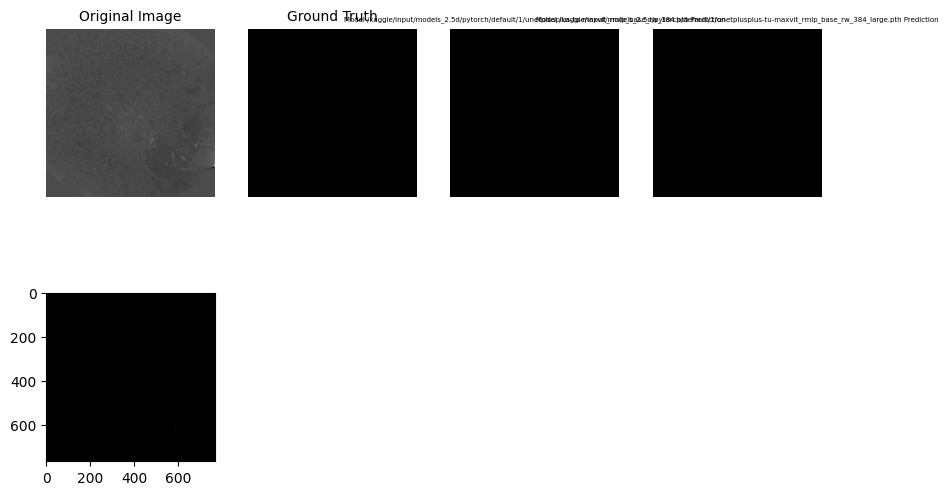

In [38]:
plot_model_comparisons(perfs, list(models.keys()))

In [ ]:
filename="class_state25d.pkl"

with open(filename, "wb") as file:
    pickle.dump(perfs, file)

filename="df_state25d.pkl"

with open(filename, "wb") as file:
    pickle.dump(perfs_df, file)